# WQU Capstone project - Short-term trading strategy on G10 currencies
## Notebook four - Fractional differentiation

* Sergey Chigrinov - chigrinov.s.88@gmail.com
* Dhruv Agrawal -  dhruva1@stanfordalumni.org
* Man Sing Ho - mshoalbert@gmail.com

### Jun-Aug-2020

Financial time series are usually non-stationary. Differentiation is the most common way to solve this. However, this approach does not keep the "memory" of a series. As an alternative option, we may use fractionally differentieted features.

In [1]:
import sys
import os
#insert you own path or use relative path
path_to_project = os.path.realpath('..') # r'C:\WQU\Capstone\Working_files'
sys.path.append(path_to_project)

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from multiprocessing import cpu_count
import warnings
warnings.filterwarnings('ignore')

In [3]:
from WQUcapstoneCode.fracdif.fracdif import frac_diff_ffd

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-talk')
plt.style.use('bmh')

In [5]:
ticker = 'AUD/USD'
input_path = os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '.csv')
features = pd.read_csv(input_path, index_col=0)

If we use large enough timespan, the data becomes stationary. For the purpose of this exercise let's exclude 33% of this data. We're going to train our data only on a part of the whole datased anyway.

In [6]:
features = features[int(len(features)/3):]

In [19]:
from statsmodels.tsa.stattools import adfuller

In [36]:
result = adfuller(features.price)

In [37]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.530173
p-value: 0.518536
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Looking at the above, we fail to reject the null hypothesis that the data is non-stationary. Therefore, we need to transform it to make it stationary.
Let's check if other features are non-stationary as well.

In [38]:
non_stationary = {col:'non-stationary' for col in features.columns if adfuller(features[col].dropna())[1]>0.05}
non_stationary

{'price': 'non-stationary',
 'fast': 'non-stationary',
 'slow': 'non-stationary',
 'average': 'non-stationary',
 'upper_band': 'non-stationary',
 'lower_band': 'non-stationary',
 'tenka_sen': 'non-stationary',
 'kijun_sen': 'non-stationary',
 'senkou_span_a': 'non-stationary',
 'senkou_span_b': 'non-stationary'}

Ok, we have a number of non-stationary variables. To make them stationary, we may use first order differencing, as below. 

In [39]:
{col:'non-stationary' for col in features.columns if adfuller(features[col].diff().dropna())[1]>0.05}

{}

However, we want to keep "memory". Therefore, we need to find a minimum value of the parameter d to make series stationary.

In [40]:
def analyze_ffd(target_col):
    cols = ['adfStat','pVal','lags','nObs','95% conf']#,'corr']
    out = pd.DataFrame(columns=cols)
    for d in np.linspace(0,1,11):
        df = frac_diff_ffd(pd.DataFrame(features[target_col].dropna()),d,thresh=1e-5)
        df = adfuller(df[target_col].dropna())
        out.loc[d]=list(df[:4])+[df[4]['5%']]
    f,ax=plt.subplots()
    out['adfStat'].plot(ax=ax, marker='X')
    ax.axhline(out['95% conf'].mean(),lw=1,color='r',ls='dotted')
    ax.set_title('min d with thresh=0.01')
    ax.set_xlabel('d values')
    ax.set_ylabel('adf stat');
    display(out)

,adfStat,pVal,lags,nObs,95% conf
0.0,-1.530173,5.185359e-01,26.0,4719.0,-2.862153
0.1,-0.985802,7.584075e-01,6.0,664.0,-2.865903
0.2,-2.058241,2.616342e-01,7.0,1357.0,-2.863672
0.3,-3.611048,5.553294e-03,26.0,2445.0,-2.862723
0.4,-4.264267,5.119450e-04,26.0,3262.0,-2.862426
0.5,-5.289950,5.744309e-06,24.0,3795.0,-2.862302
0.6,-6.611523,6.359304e-09,24.0,4132.0,-2.862240
0.7,-8.102414,1.289225e-12,24.0,4350.0,-2.862205
0.8,-9.777901,6.856305e-17,24.0,4494.0,-2.862183
0.9,-10.832800,1.691283e-19,25.0,4596.0,-2.862169


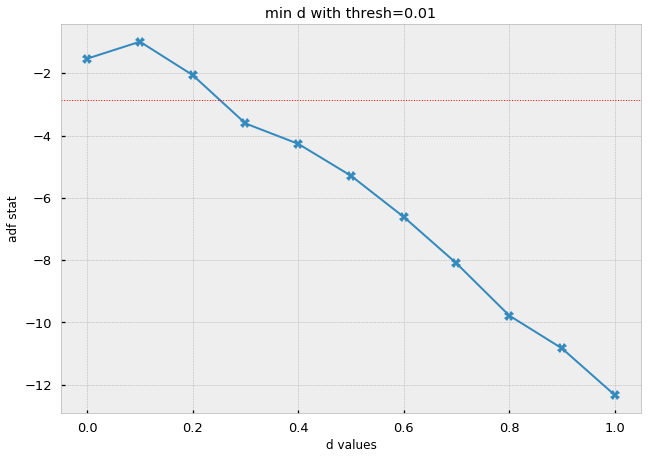

In [41]:
analyze_ffd('price')

From the above chart it can be seen that d-value above 0.2 allows to make the price time series stationary. First-differencing is equivalent to d=1. To decide on d, we may experiment with ofther non-stationary columns. 

,adfStat,pVal,lags,nObs,95% conf
0.0,-1.482826,5.419895e-01,21.0,4724.0,-2.862152
0.1,-1.134674,7.010482e-01,5.0,665.0,-2.865896
0.2,-1.870872,3.458856e-01,10.0,1354.0,-2.863677
0.3,-3.776981,3.151803e-03,19.0,2452.0,-2.862719
0.4,-4.581603,1.396396e-04,19.0,3269.0,-2.862425
0.5,-5.725840,6.774644e-07,19.0,3800.0,-2.862301
0.6,-7.143825,3.271706e-10,19.0,4137.0,-2.862239
0.7,-8.574161,8.047031e-14,19.0,4355.0,-2.862204
0.8,-10.222635,5.275675e-18,20.0,4498.0,-2.862183
0.9,-11.536545,3.721430e-21,20.0,4601.0,-2.862168


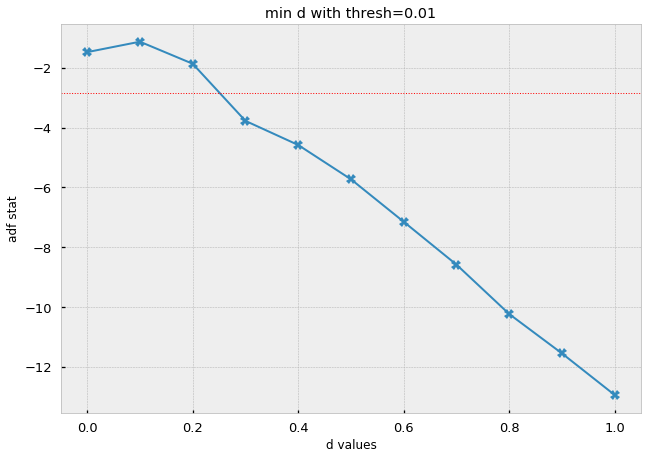

In [42]:
analyze_ffd('upper_band')

,adfStat,pVal,lags,nObs,95% conf
0.0,-1.499056,5.339784e-01,29.0,4716.0,-2.862153
0.1,-0.892397,7.904660e-01,8.0,662.0,-2.865916
0.2,-1.627469,4.688157e-01,18.0,1346.0,-2.863690
0.3,-2.622484,8.843869e-02,27.0,2444.0,-2.862723
0.4,-2.999581,3.493353e-02,3.0,3285.0,-2.862420
0.5,-3.830713,2.608258e-03,10.0,3809.0,-2.862299
0.6,-5.003118,2.187992e-05,11.0,4145.0,-2.862238
0.7,-4.964009,2.613603e-05,28.0,4346.0,-2.862205
0.8,-5.870908,3.242006e-07,28.0,4490.0,-2.862184
0.9,-6.426037,1.743635e-08,32.0,4589.0,-2.862170


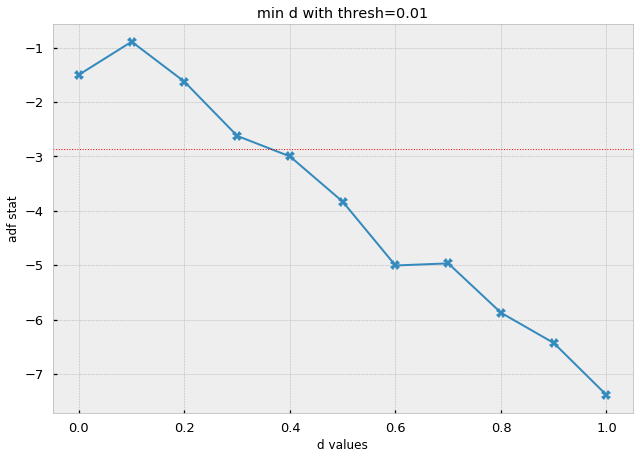

In [43]:
analyze_ffd('senkou_span_b')

Optionally, we may tweak the analyze_ffd function to return the minimum value of d that makes a series stationary. However, experiments show, that d=0.35 is applicable in most cases. Therefore, to we may reduce computational cost and use this constant.

In [44]:
d=0.35

In [45]:
df = pd.concat([frac_diff_ffd(pd.DataFrame(features[c].dropna()), diff_amt=d, thresh=1e-5)  for c in non_stationary.keys()], axis = 1)

In [46]:
non_stationary = {col:'non-stationary' for col in df.columns if adfuller(df[col].dropna())[1]>0.05}
non_stationary

{'senkou_span_b': 'non-stationary'}

After the above operation, all features except for 'senkou_span_b' are stationary.
However, as a result of this operation we lost a significant number of rows because they were used to 'smooth' the differencing.

In [47]:
print(f'''Initial number of rows:        {features.shape[0]}
Number of rows after fracDiff: {df.dropna().shape[0]}''')

Initial number of rows:        4746
Number of rows after fracDiff: 2921


### Conclusion
Fractionally differentiated features can be used in further analysis as inputs for machine learning models. However, to have enough data we may need to increase our the time span of the input data. 